# Setup

**Imports**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
import pandas as pd

from ruptures.metrics import hamming
import statistics
from scipy.stats import linregress
from scipy.linalg import eigh
from loadmydata.load_molene_meteo import load_molene_meteo_dataset

import geopandas
from scipy.spatial.distance import pdist, squareform
from math import asin, cos, radians, sin, sqrt
from pygsp import graphs
import contextily as cx
from matplotlib.dates import DateFormatter

In [5]:
CRS = "EPSG:4326"

**Utility functions**

In [6]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.margins(x=0)
    return fig, ax

def dms2dd(s):
    """Convert longitude and latitude strings to float."""
    # https://stackoverflow.com/a/50193328
    # example: s =  """48°51'18"""
    degrees, minutes, seconds = re.split("[°'\"]+", s[:-1])
    direction = s[-1]
    dd = float(degrees) + float(minutes) / 60 + float(seconds) / (60 * 60)
    if direction in ("S", "W"):
        dd *= -1
    return dd

def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def get_exponential_similarity(
    condensed_distance_matrix, bandwidth, threshold
):
    exp_similarity = np.exp(
        -(condensed_distance_matrix ** 2) / bandwidth / bandwidth
    )
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

# Question 2

In [6]:
list_sigma = [1, 2, 5, 7]
list_T = [100, 200, 500, 1000]
list_n_bkps = [2, 4, 6, 8, 10]

def sample_signal(T, bkps, sigma):
    return rpt.pw_constant(n_samples=T, n_features=2, n_bkps=bkps, noise_std=sigma)

def penalisation(signal):
    T = signal.shape[0]
    estim_sigma = statistics.variance(signal[:int(T//10),0])
    return 2 * estim_sigma


In [10]:
# to detect mean shift, use the faster dynamic programming algorithm in rpt.KernelCPD(kernel="linear")
T=200
n_bkps = 5
sigma = 2
signal, breakpoints = sample_signal(T, n_bkps, sigma)
algo = rpt.KernelCPD(kernel="linear").fit(signal)

pred_bkps = algo.predict(n_bkps)  # detects n_bkps change-points
print("Breakpoints", breakpoints)
print("Breakpoints detected knowing n_bkps", pred_bkps) 
print("Resulting Hamming loss", hamming(breakpoints, pred_bkps))

pen=penalisation(signal)
id_pen = 2*sigma**2
pred_bkps = algo.predict(pen=id_pen)  # minimizes the linearly penalized sum of costs (with beta=10)
print("Breakpoints detected with penalisation", pred_bkps) 
print("Resulting Hamming loss", hamming(breakpoints, pred_bkps))

Breakpoints [32, 67, 100, 137, 168, 200]
Breakpoints detected knowing n_bkps [32, 67, 100, 137, 168, 200]
Resulting Hamming loss 0.0
Breakpoints detected with penalisation [4, 13, 24, 27, 32, 36, 42, 47, 50, 52, 63, 65, 67, 69, 71, 74, 77, 83, 87, 90, 92, 95, 97, 100, 106, 113, 117, 121, 124, 126, 132, 137, 140, 142, 145, 148, 150, 152, 155, 158, 160, 163, 168, 172, 174, 176, 181, 183, 186, 189, 192, 198, 200]
Resulting Hamming loss 0.1432663316582914


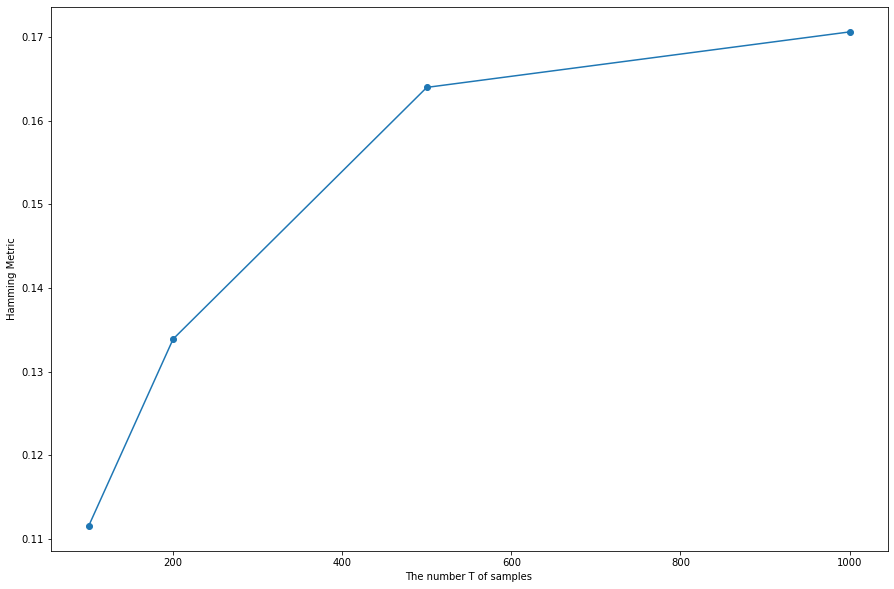

In [11]:
sigma = 2
# bkps = 5
list_hamming = []
for t in list_T:
    list_hamming.append(0)
    for n_bkps in list_n_bkps:
        signal, breakpoints = sample_signal(t, n_bkps, sigma)
        algo = rpt.KernelCPD(kernel="linear").fit(signal)
        predicted_breakpoints = algo.predict(pen=penalisation(signal)) 
        list_hamming[-1] += hamming(breakpoints, predicted_breakpoints)

    # Average over all values of n_bkps
    list_hamming[-1] /= len(list_n_bkps)


plt.figure(figsize=(15,10))
plt.plot(list_T, list_hamming, marker='o')
plt.xlabel("The number T of samples")
plt.ylabel('Hamming Metric')
plt.savefig(fname=f"q2_1.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)
plt.show()



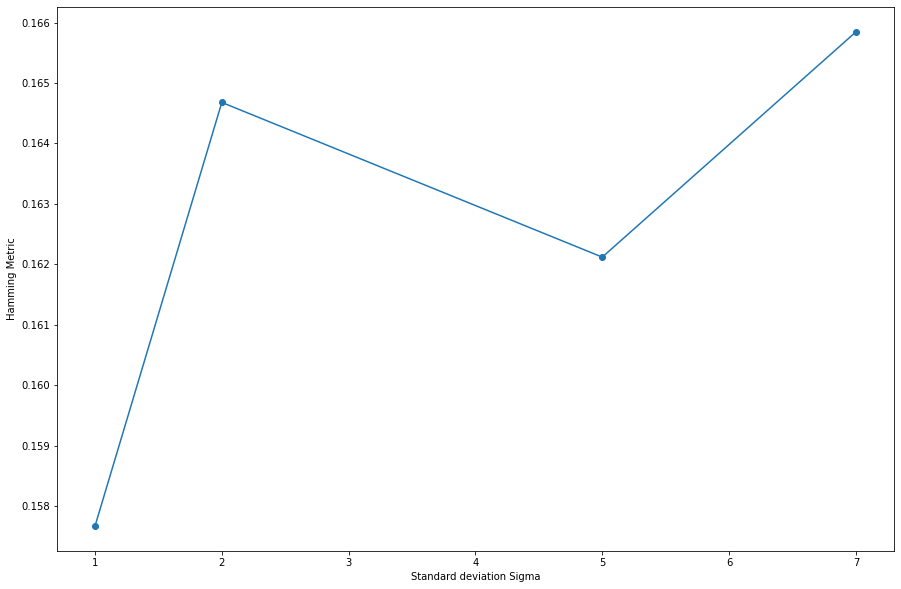

In [12]:
T = 500
# bkps = 5
list_hamming = []
for s in list_sigma:
    list_hamming.append(0)
    # For each nulber of brekpoints
    for n_bkps in list_n_bkps:
        signal, breakpoints = sample_signal(T, n_bkps, s)
        algo = rpt.KernelCPD(kernel="linear").fit(signal)
        predicted_breakpoints = algo.predict(pen=penalisation(signal)) 
        list_hamming[-1] += (hamming(breakpoints, predicted_breakpoints))
    # Average over all values of n_bkps
    list_hamming[-1]/= len(list_n_bkps)


plt.figure(figsize=(15,10))
plt.plot(list_sigma, list_hamming, marker = 'o')
plt.xlabel("Standard deviation Sigma")
plt.ylabel('Hamming Metric')
plt.savefig(fname=f"q2_2.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)
plt.show()

# Question 3

In [13]:
T = 100
s = 2.
n_bkps = 5


def estimate_slope(signal):
    T = signal.shape[0]
    signal, breakpoints = sample_signal(T, n_bkps, s)
    algo = rpt.KernelCPD(kernel="linear").fit(signal)

    c = rpt.costs.CostL2().fit(signal)
    list_large_K = np.linspace(15, int(.4*T), 20)
    list_errors = [c.sum_of_costs(algo.predict(n_bkps=K)) for K in list_large_K]

    return linregress(list_large_K, list_errors).slope



In [14]:
def penalisation_slope(signal):
  T = signal.shape[0]
  slope = estimate_slope(signal)
  # C_slope*d = -T*s_hat*d
  return -slope*2


In [15]:
sigma = 2
# bkps = 5
list_hamming = []
for t in list_T:
    print("T =", t)
    list_hamming.append(0)
    for n_bkps in list_n_bkps:
        signal, breakpoints = sample_signal(t, n_bkps, sigma)
        algo = rpt.KernelCPD(kernel="linear").fit(signal)
        predicted_breakpoints = algo.predict(pen=penalisation_slope(signal)) 
        list_hamming[-1] += hamming(breakpoints, predicted_breakpoints)

    # Average over all values of n_bkps
    list_hamming[-1] /= len(list_n_bkps)
  

T = 100
T = 200
T = 500
T = 1000


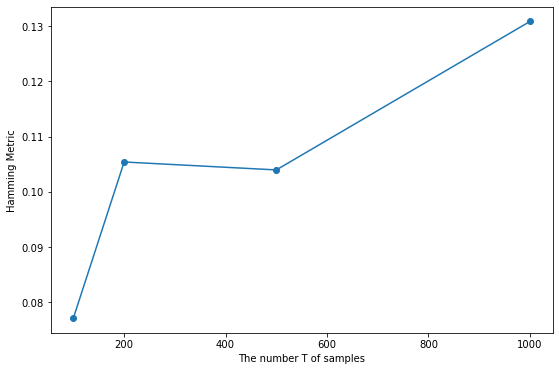

In [16]:
plt.figure(figsize=(9,6))
plt.plot(list_T, list_hamming, marker='o')
plt.xlabel("The number T of samples")
plt.ylabel('Hamming Metric')
plt.savefig(fname=f"q3_1.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)
plt.show()

In [256]:
T = 500
list_hamming = []
for s in list_sigma:
  list_hamming.append(0)
  # For each number of brekpoints
  for n_bkps in list_n_bkps:
    signal, breakpoints = sample_signal(T, n_bkps, s)
    algo = rpt.KernelCPD(kernel="linear").fit(signal)
    predicted_breakpoints = algo.predict(pen=penalisation_slope(signal)) 
    list_hamming[-1] += (hamming(breakpoints, predicted_breakpoints))
  # Average over all values of n_bkps
  list_hamming[-1]/= len(list_n_bkps)

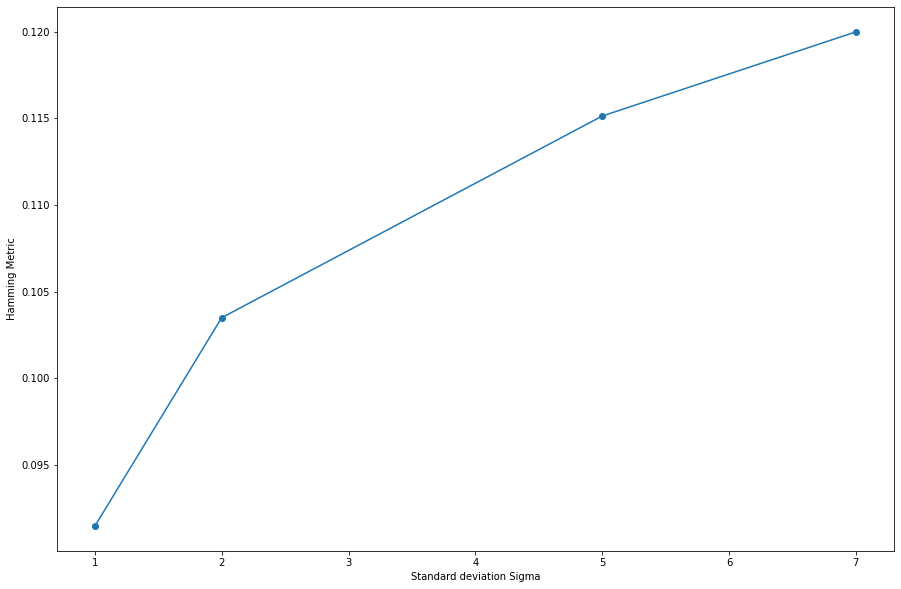

In [257]:
plt.figure(figsize=(15,10))
plt.plot(list_sigma, list_hamming, marker = 'o')
plt.xlabel("Standard deviation Sigma")
plt.ylabel('Hamming Metric')
plt.savefig(fname=f"q3_2.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)
plt.show()

# Question 4

In [7]:
def g(lambd, m, R=3):
  a = LAMBDA_N/(M+1-R)

  lam = lambd -a*m
  lam = lam*((lam < 0) & (lam >= -R*a))

  return .5*(1+np.cos(2*np.pi*(.5 + lam/(a*R))))

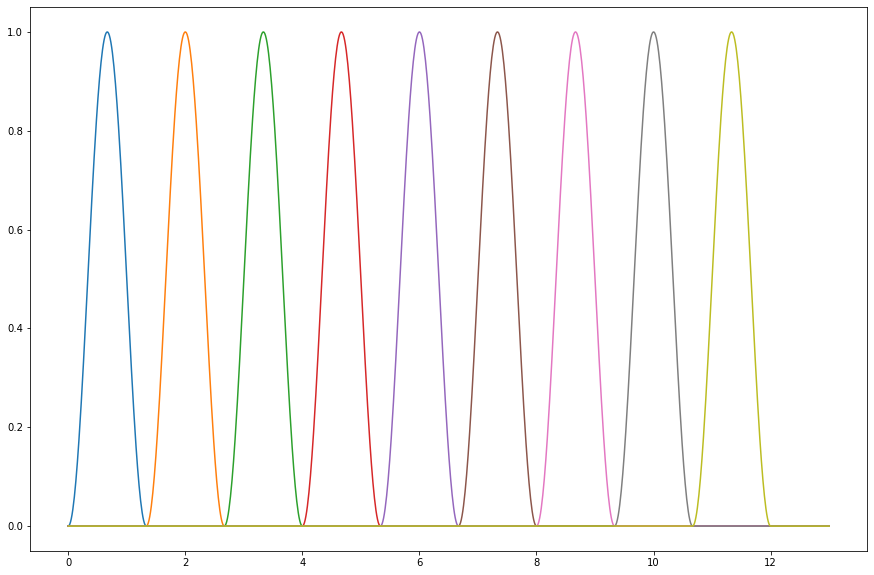

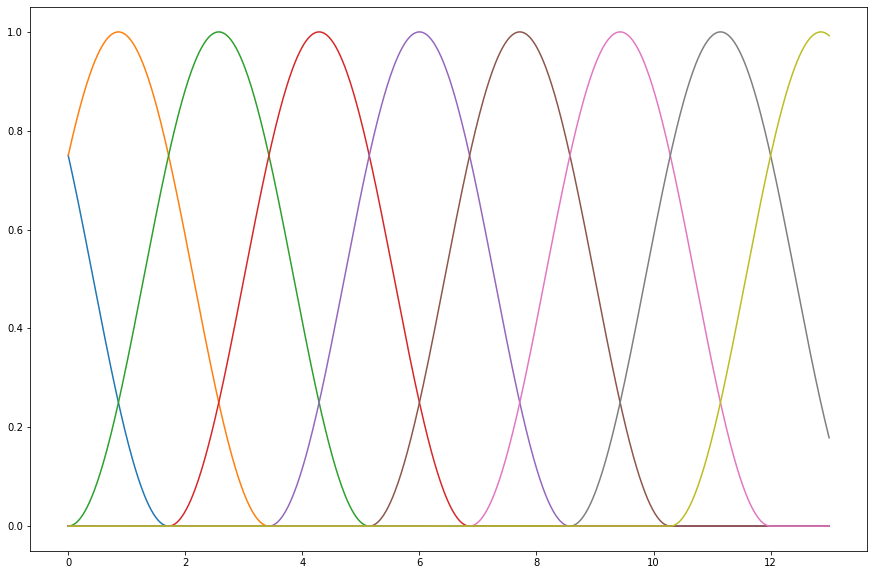

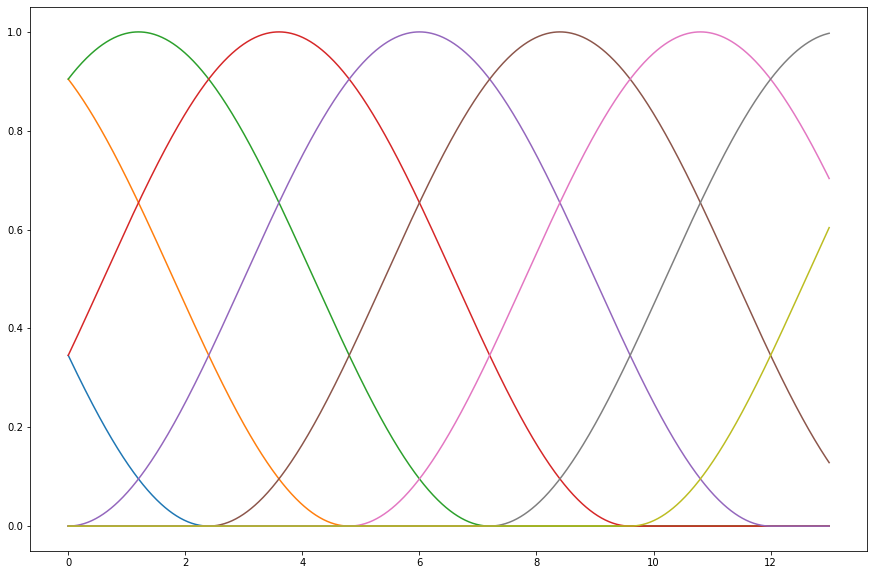

In [8]:
M = 9
LAMBDA_N = 12

lam = np.linspace(0, LAMBDA_N +1, 1000)

for R in [1,3,5]:
  plt.figure(figsize = (15,10))
  for m in range(1,M+1):
    plt.plot(lam, g(lam, m, R), label = "m=" + str(m) )
  plt.savefig(fname=f"q4_R="+str(R)+".pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)
  plt.show()

# Question 5

,Numéro,Nom,Latitude,Longitude,X (Lambert II étendu),Y (Lambert II étendu),Altitude,geometry
0,22016001,ILE-DE-BREHAT,48.855167,-3.004500,208083,2441852,25,POINT (-3.00450 48.85517)
1,22092001,KERPERT,48.404000,-3.147667,194096,2392507,281,POINT (-3.14767 48.40400)
2,22113006,LANNAERO,48.755333,-3.468667,173267,2433190,85,POINT (-3.46867 48.75533)
3,22135001,LOUARGAT,48.551667,-3.376833,178359,2410097,148,POINT (-3.37683 48.55167)
4,22147006,MERDRIGNAC,48.182667,-2.410833,247067,2364385,131,POINT (-2.41083 48.18267)


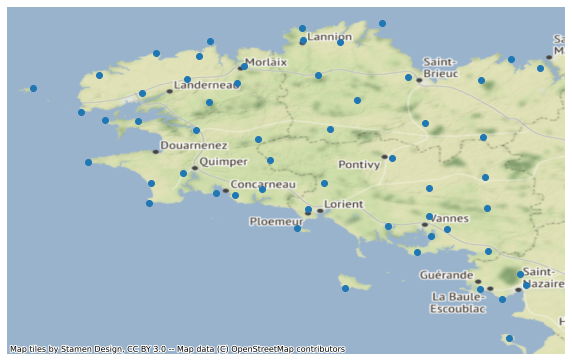

In [45]:
data_df, stations_df, description = load_molene_meteo_dataset()
# only keep a subset of stations
# keep_cond = stations_df.Nom.isin(STATION_LIST)
# stations_df = stations_df[keep_cond]
# keep_cond = data_df.station_name.isin(STATION_LIST)
data_df = data_df.reset_index().drop("index", axis="columns")

# convert temperature from Kelvin to Celsius
data_df["temp"] = data_df.t - 273.15  # temperature in Celsius

# convert pandas df to geopandas df
stations_gdf = geopandas.GeoDataFrame(
    stations_df,
    geometry=geopandas.points_from_xy(
        stations_df.Longitude, stations_df.Latitude
    ),
).set_crs(CRS)

ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()

stations_gdf.head()

In [46]:
# Stations with missing values
temperature_df = data_df.pivot(
    index="date", values="temp", columns="station_name"
)
temperature_df_no_nan = temperature_df.dropna(axis=1, how="any")

print("Number of missing values per station\n", temperature_df.isna().sum(axis=0).sort_values(ascending=False))

print("\nNumber of stations with missing values", temperature_df.shape[1]-temperature_df_no_nan.shape[1])
print("\nStations with missing values:")
for elmt in temperature_df.columns:
    if elmt not in temperature_df_no_nan.columns:
        print(elmt)


Number of missing values per station
 station_name
BATZ                   744
BEG_MEIL               744
CAMARET                744
PLOUGONVELIN           744
RIEC SUR BELON         144
ST NAZAIRE-MONTOIR      70
PLOUAY-SA               63
VANNES-MEUCON           50
LANNAERO                37
PLOUDALMEZEAU            2
LANDIVISIAU              1
SIZUN                    1
QUIMPER                  1
OUESSANT-STIFF           1
LANVEOC                  1
ARZAL                    1
BREST-GUIPAVAS           1
BRIGNOGAN                1
SIBIRIL S A              0
DINARD                   0
QUINTENIC                0
ROSTRENEN                0
SAINT-CAST-LE-G          0
SAINT-JOACHIM_SAE        0
SARZEAU SA               0
KERPERT                  0
PTE DE PENMARCH          0
SPEZET                   0
ST BRIEUC                0
BIGNAN                   0
ST-SEGAL S A             0
THEIX                    0
TREGUNC                  0
BELLE ILE-LE TALUT       0
PTE DU RAZ               0
PTE 

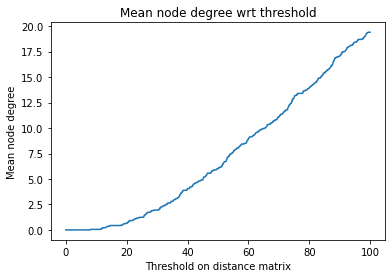

Minimum threshold such that the network is connected and the average degree is at least 3 : 39.900000000000006
The graph is connected, with 37 nodes, 75 edges


In [47]:

# Similarity and distance matrix 
stations_df = stations_df[stations_df.Nom.isin(temperature_df_no_nan.columns)]
stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

# Plot mean degree wrt to threshold
thresholds_list = np.linspace(0, 100, 1001)
degrees = []
best_thresholds = []
for threshold in thresholds_list:
    adjacency_matrix = squareform((dist_mat_condensed < threshold).astype(int))
    degree = adjacency_matrix.sum(axis = 1).mean()
    G = graphs.Graph(adjacency_matrix)
    degrees.append(degree)
    if G.is_connected(recompute=True) and degree>=3:
        best_thresholds.append(threshold)

plt.plot(thresholds_list, degrees)
plt.title("Mean node degree wrt threshold")
plt.xlabel("Threshold on distance matrix")
plt.ylabel("Mean node degree")
plt.show()
print("Minimum threshold such that the network is connected and the average degree is at least 3 :", np.min(best_thresholds))

# Graph with mean threshold 
adjacency_matrix = squareform((dist_mat_condensed < np.min(best_thresholds)).astype(int))
G = graphs.Graph(adjacency_matrix)
print(
    f"The graph is {'not ' if not G.is_connected(recompute=True) else ''}connected, with {G.N} nodes, {G.Ne} edges"
)

Each vertex can be connected to other vertices by edges weighted by a Gaussian kernel:
$$
W_{ij} = \exp\left(-\frac{\|c_i-c_j\|^2}{\sigma^2}\right) \quad\text{if}\quad \exp\left(-\frac{\|c_i-c_j\|^2}{\sigma^2}\right)>\lambda,\ 0\ \text{otherwise}
$$
where the $c_i$ are the station positions, $\sigma$ is the so-called bandwidth parameter, and $\lambda>0$ is a threshold. 


Therefore, the previously defined threshold T is such that $\lambda = \exp\left(-\frac{T^2}{\sigma^2}\right)$

In [48]:
# Compute graph with given threshold
sigma = np.median(dist_mat_condensed)  # median heuristic
threshold = np.exp(-(np.min(best_thresholds)/sigma)**2) # maximum threshold from the minimum threshold
adjacency_matrix_gaussian = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))
G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
print("Threshold for gaussian kernel", threshold)
print(
    f"The graph is {'not ' if not G_gaussian.is_connected(recompute=True) else ''}connected, with {G_gaussian.N} nodes, {G_gaussian.Ne} edges"
)

Threshold for gaussian kernel 0.8321157232737325
The graph is connected, with 37 nodes, 75 edges


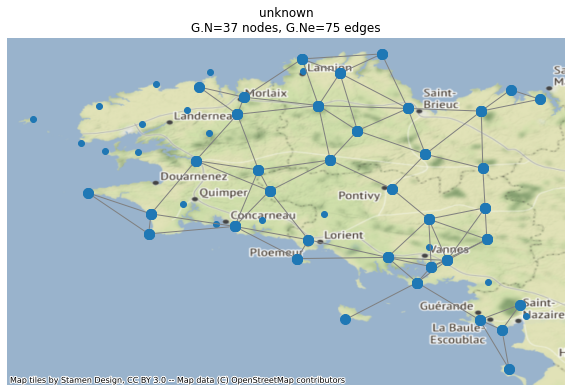

In [49]:
# Plot map
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot(ax=ax)

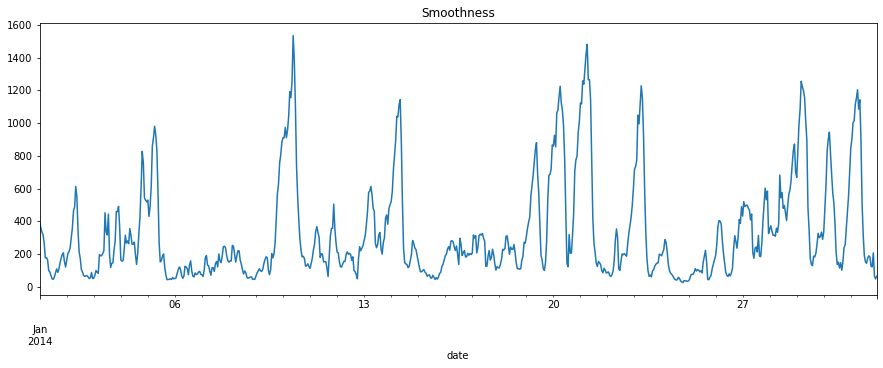

In [53]:
laplacian_matrix = G_gaussian.L.todense()

# Plot smoothmness over time
signals = temperature_df_no_nan.to_numpy()
smoothness_arr = np.array(
    [float(signal.T.dot(laplacian_matrix).dot(signal)) for signal in signals]
)
smoothness_df = pd.Series(
    data=smoothness_arr, index=temperature_df_no_nan.index
)

fig, ax = fig_ax()
smoothness_df.plot(ax=ax)
ax.set_title("Smoothness")
plt.grid(axis="x", color="0.95")

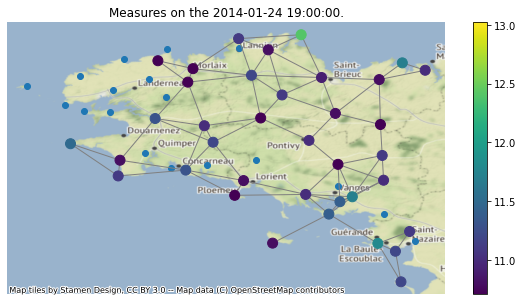

In [15]:
# when the signal is the smoothest
argmin_index = smoothness_df.argmin()
signal = temperature_df_no_nan.iloc[argmin_index].to_numpy()
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(signal, ax=ax)
_ = ax.set_title(
    f"Measures on the {temperature_df_no_nan.index[argmin_index]}."
)

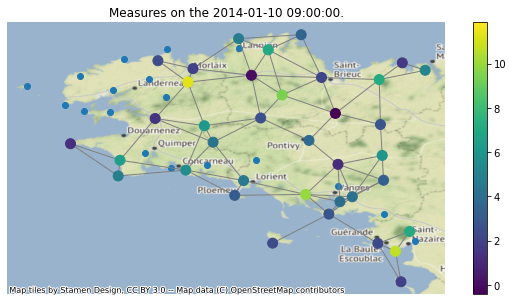

In [16]:
# when the signal is the least smooth.
argmax_index = smoothness_df.argmax()
signal = temperature_df_no_nan.iloc[argmax_index].to_numpy()
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(signal, ax=ax)
_ = ax.set_title(
    f"Measures on the {temperature_df_no_nan.index[argmax_index]}."
)

# Question 6

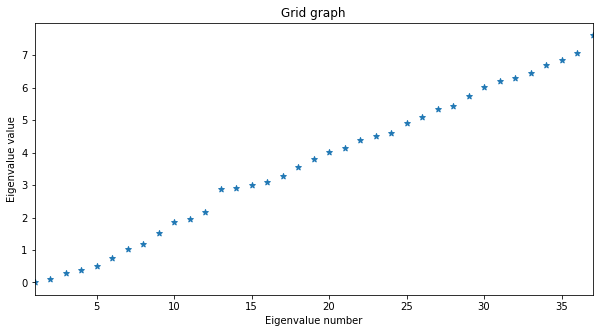

In [17]:
# Laplacian eigendecomposition
eigenvals, eigenvects= eigh(G_gaussian.L.todense())

fig, ax_0 = fig_ax(figsize=(10, 5))
ax_0.scatter(range(1, eigenvals.size + 1), eigenvals, marker =  "*")
ax_0.set_xlabel("Eigenvalue number")
ax_0.set_ylabel("Eigenvalue value")
_ = ax_0.set_title("Grid graph")
plt.show()


In [66]:
def gwt_coeff(fourier_f, eigenvects, eigenvals, v, m):
    """ Computes GWT coefficients """
    return (fourier_f*eigenvects[:, v]*g(eigenvals, m)).sum()

def get_labels(signal, eigenvals, eigenvects):
    """ Compute the frequency classes of the nodes given the signal and eigenvals/vects"""
    signal_fourier = eigenvects.T.dot(signal)

    list_m = range(1, 9+1)
    node_labels = []  # 0 for low-freq, 1 for medium, 2 for high-freq
    
    for v in range(eigenvals.shape[0]):
        node_features = np.array([gwt_coeff(signal_fourier, eigenvects, eigenvals, v, m) for m in list_m])
        energies = [(node_features[3*i:3*i+3]**2).sum() for i in range(3)]
        node_labels.append(np.argmax(energies))

    return node_labels

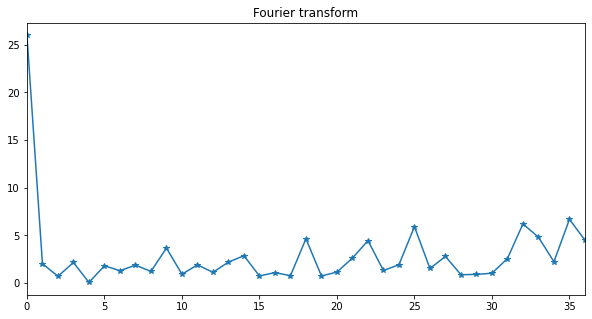

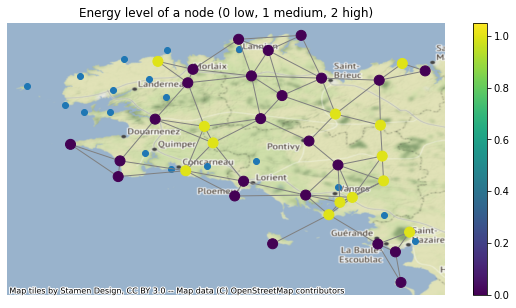

In [61]:
# Fourier transform of the signal the least smooth.
index = smoothness_df.argmax()
signal = signals[index]
signal_fourier = eigenvects.T.dot(signal)

# plot
fig, ax_0 = fig_ax(figsize=(10, 5))
ax_0.plot(abs(signal_fourier), "*-")
ax_0.set_title("Fourier transform")
plt.show()

# Get coeffs
node_labels =  get_labels(signal, eigenvals, eigenvects)

# print Map
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(np.array(node_labels), ax=ax)
_ = ax.set_title(
    f"Energy level of a node (0 low, 1 medium, 2 high)"
)
plt.savefig(fname=f"q6_laest_smooth.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)


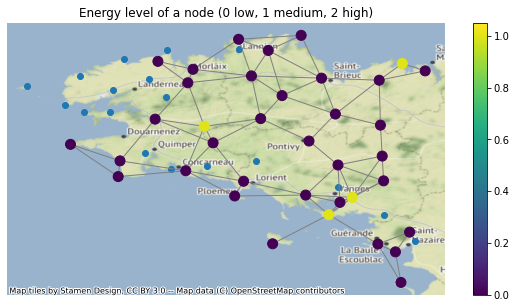

In [62]:
# Fourier transform of the smoothest signal.
index = smoothness_df.argmin()
node_labels =  get_labels(signals[index], eigenvals, eigenvects)

# print Map
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(np.array(node_labels), ax=ax)
_ = ax.set_title(
    f"Energy level of a node (0 low, 1 medium, 2 high)"
)
plt.savefig(fname=f"q6_smoothest.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)


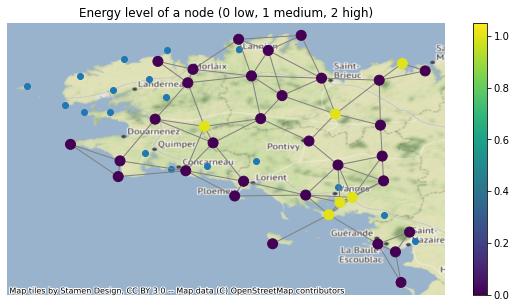

In [63]:
# Fourier transform of the signal the first timestamp
index = 0
node_labels =  get_labels(signals[index], eigenvals, eigenvects)

# print Map
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(np.array(node_labels), ax=ax)
_ = ax.set_title(
    f"Energy level of a node (0 low, 1 medium, 2 high)"
)
plt.savefig(fname=f"q6_first_time.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)


# Question 7

In [64]:
# from matplotlib.cbook import get_label
y = np.mean(signals, axis=1)
x = np.arange(y.shape[0])
labels = np.array([get_labels(signal, eigenvals, eigenvects) for signal in signals])

class_array = [np.argmax(np.bincount(label)) for label in labels]  #  classes (0, 1, 2)

# do not forget to explain the colours in the reportc

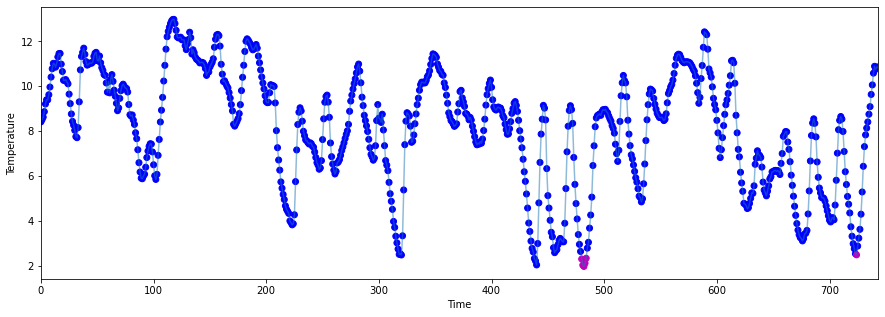

In [65]:
colors = ["b", "m", "r"]  # three colours=three classes
color_array = np.take(colors, class_array)
fig, ax = fig_ax()
ax.plot(x, y, alpha=0.5)
ax.scatter(x, y, c=color_array)
plt.xlabel('Time')
plt.ylabel('Temperature')

plt.savefig(fname=f"q7.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)

# Question 8

In [68]:
def get_label_one_fourier(signal_FOURIER, eigenvals, eigenvects, v):
    """
    For memory issues:
    Return the class of a single given node v, given the fourier transform of the signal and the eigenvalues and eigenvectors 
    
    """
    node_features = np.array([gwt_coeff(signal_FOURIER, eigenvects, eigenvals, v, m) for m in range(1,10)])
    energies = [(node_features[i:i+3]**2).sum() for i in range(3)]

    return np.argmax(energies)

In [24]:
m,n  = signals.shape

# Temporal graph, build laplacian and get eigen vals/vects
L_prime = np.eye(m) - np.eye(m,m,1) - np.eye(m,m,1).T 
L_prime[1:-1, 1:-1] += np.eye(m-2)
eigenvals_prime, eigenvects_prime = eigh(L_prime)
eigenvals, eigenvects= eigh(G_gaussian.L.todense())

# Spatial graph eigen vals/vects
eigenvects = eigenvects.astype(np.float16)
eigenvects_prime = eigenvects_prime.astype(np.float16)


In [25]:
# Compute eigenvals/vects of the spatio-temporal graph
eigenvects_tot = np.kron(eigenvects_prime, eigenvects)
eigenvals_tot = np.kron(np.ones(m), eigenvals) + np.kron(eigenvals_prime, np.ones(n))

# Full concatenated signal (in the right order: space dimension first)
signal_tot = signals.flatten()

# Compute once the fourier transform of the signal
fourier_tot = np.dot(eigenvals_tot, eigenvects_tot)

In [69]:
# To save RAM, compute the labels node by node with the custom function above
labels_tot = []
for v in range(m*n):
    labels_tot.append(get_label_one_fourier(fourier_tot, eigenvals_tot, eigenvects_tot, v))
    if not v%1000: print(str(v)+"/"+str(m*n))

0/27528
1000/27528
2000/27528
3000/27528
4000/27528
5000/27528
6000/27528
7000/27528
8000/27528
9000/27528
10000/27528
11000/27528
12000/27528
13000/27528
14000/27528
15000/27528
16000/27528
17000/27528
18000/27528
19000/27528
20000/27528
21000/27528
22000/27528
23000/27528
24000/27528
25000/27528
26000/27528
27000/27528


In [70]:
y = np.mean(signals, axis=1)
x = np.arange(y.shape[0])
labels = np.array(labels_tot).reshape((m,n))

class_array = [np.argmax(np.bincount(label)) for label in labels]  #  classes (0, 1, 2)
# do not forget to explain the colours in the reportc

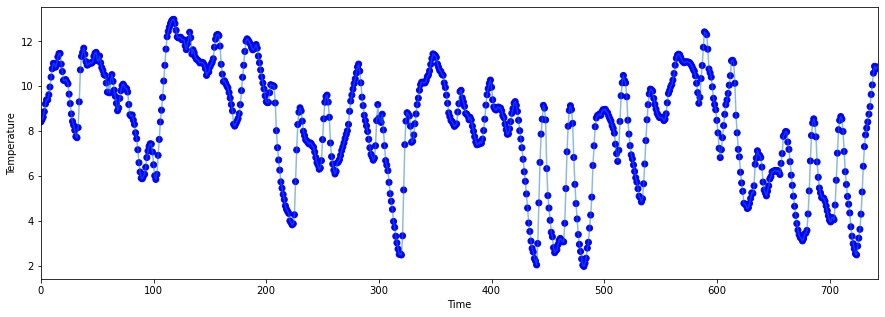

In [71]:
colors = ["b", "m", "r"]  # three colours=three classes
color_array = np.take(colors, class_array)
fig, ax = fig_ax()
ax.plot(x, y, alpha=0.5)
ax.scatter(x, y, c=color_array)
plt.xlabel('Time')
plt.ylabel('Temperature')

plt.savefig(fname=f"q8.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)